## Training and evaluation of Classical ML methods (RF, SVM, Logistic Regression)

In [1]:
import pandas as pd
import numpy as np
import joblib as jbl
from sklearn.model_selection import PredefinedSplit
from scipy.sparse import vstack
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

Loading or train/test data and multihot targets, we also want to get label names, so we extract them from columns in "preprocessed_df"

In [2]:
y_train = jbl.load("y_train.pkl")
y_test = jbl.load("y_test.pkl")
label_names = jbl.load("preprocessed_df.pkl").columns[3:-1]
print(label_names)
y_full = np.concatenate([y_train, y_test], axis = 0)
print(y_full.shape)

Index(['related', 'request', 'offer', 'aid_related', 'medical_help',
       'medical_products', 'search_and_rescue', 'security', 'military',
       'water', 'food', 'shelter', 'clothing', 'money', 'missing_people',
       'refugees', 'death', 'other_aid', 'infrastructure_related', 'transport',
       'buildings', 'electricity', 'tools', 'hospitals', 'shops',
       'aid_centers', 'other_infrastructure', 'weather_related', 'floods',
       'storm', 'fire', 'earthquake', 'cold', 'other_weather',
       'direct_report'],
      dtype='object')
(26216, 35)


### Bag of word representations

In [3]:
bow_train = jbl.load("bow_train.pkl")
bow_test = jbl.load("bow_test.pkl")
bow_full = vstack([bow_train, bow_test])
print(bow_full.shape)

(26216, 6224)


### Tfidf representations

In [4]:
tfidf_train = jbl.load("tfidf_train.pkl")
tfidf_test = jbl.load("tfidf_test.pkl")
tfidf_full =  vstack([tfidf_train, tfidf_test])
print(tfidf_full.shape)

(26216, 6224)


### Sense vector representations

In [5]:
sense_train = jbl.load("sense_vectors_train.pkl")
sense_test = jbl.load("sense_vectors_test.pkl")
sense_full = np.concatenate([sense_train, sense_test], axis=0)
print(sense_full.shape)

(26216, 100)


### Predefined split for the GridSearch

In [6]:
test_fold = np.zeros(len(y_full))
test_fold[:len(y_train)] = -1
split = PredefinedSplit(test_fold)

## SVM
Using LinearSVC, it is Similar to SVC with parameter kernel='linear', but implemented in terms of liblinear rather than libsvm, so it has more flexibility in the choice of penalties and loss functions and should scale better to large numbers of samples.

## Bow vectors

In [7]:
from sklearn.svm import LinearSVC
from sklearn.multioutput import MultiOutputClassifier
from sklearn.model_selection import GridSearchCV
param_grid = {
    'estimator__C': [0.1, 1, 10],
    'estimator__penalty': ["l2"]
}
mutli_svm = MultiOutputClassifier(LinearSVC(), n_jobs=-1)
clf = GridSearchCV(mutli_svm, param_grid=param_grid, scoring="f1_macro", cv = split, verbose=4, refit=False)
clf.fit(bow_full, y_full)
print(clf.best_params_)
mutli_svm_bow = mutli_svm.set_params(**clf.best_params_)
mutli_svm_bow.fit(bow_train, y_train)
preds = mutli_svm_bow.predict(bow_test)

Fitting 1 folds for each of 3 candidates, totalling 3 fits
[CV 1/1] END estimator__C=0.1, estimator__penalty=l2;, score=0.415 total time=   7.1s
[CV 1/1] END estimator__C=1, estimator__penalty=l2;, score=0.401 total time=  19.5s
[CV 1/1] END estimator__C=10, estimator__penalty=l2;, score=0.361 total time=  47.5s
{'estimator__C': 0.1, 'estimator__penalty': 'l2'}


In [8]:
def results(y_test, preds, labels):
    def plot_cms(y_test, preds, labels):
        plt.figure(figsize=(15,15))
        for i in range(len(labels)):
            plt.subplot(6,6,i+1)
            plt.title(f"{labels[i]}")
            cm = confusion_matrix(y_test[:, i], preds[:, i], normalize = "true")
            sns.heatmap(cm, annot=True, fmt=".2f", cbar=False, cmap="mako")
            plt.ylabel("True")
            plt.xlabel("Pred")
        plt.tight_layout()
        plt.suptitle("Per class confusion matrices, normilized by true (diagonal is recall)")
        plt.subplots_adjust(top=0.95)
        plt.show()
    plot_cms(y_test, preds, labels)
    cr = classification_report(y_test, preds, target_names=labels, zero_division=0)
    print(cr)

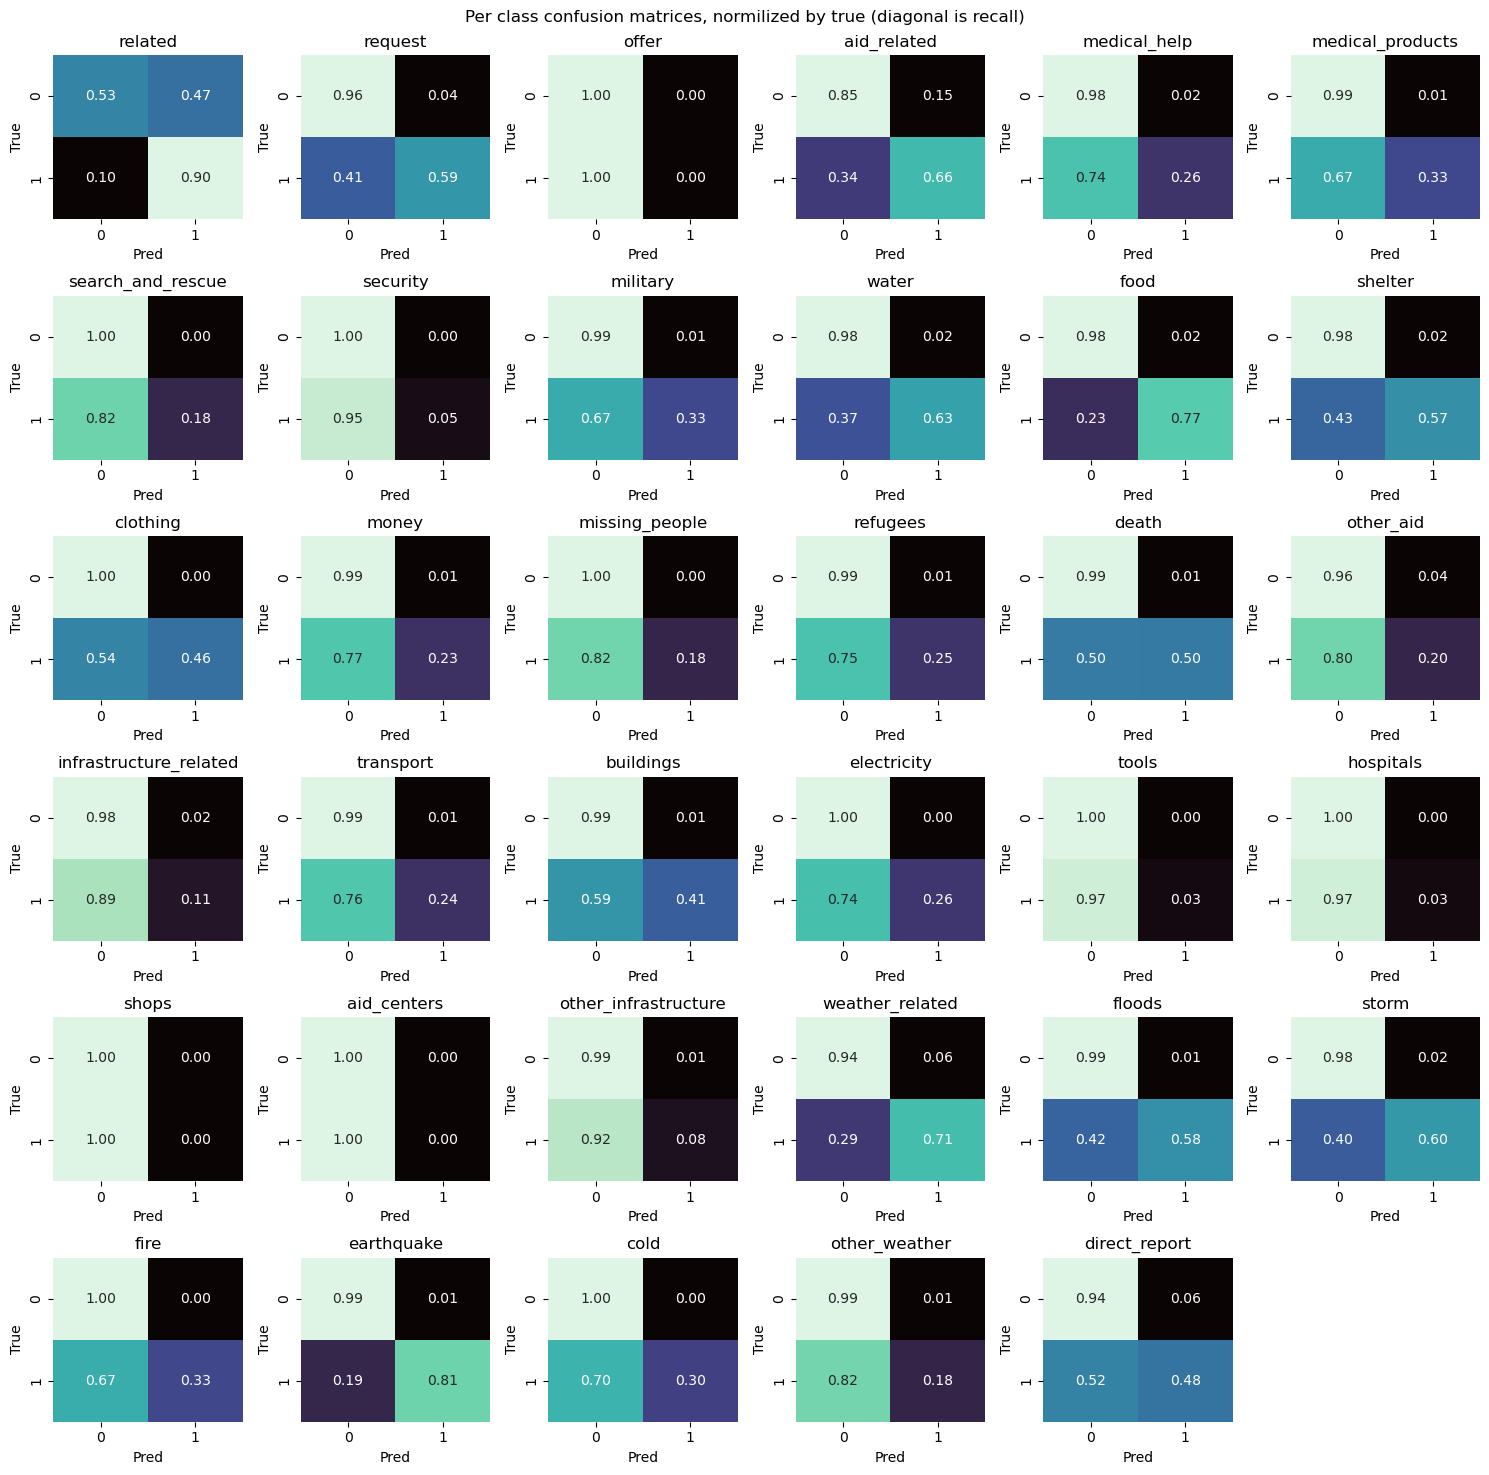

                        precision    recall  f1-score   support

               related       0.86      0.90      0.88      4018
               request       0.74      0.59      0.66       911
                 offer       0.00      0.00      0.00        21
           aid_related       0.76      0.66      0.71      2232
          medical_help       0.54      0.26      0.35       438
      medical_products       0.63      0.33      0.43       265
     search_and_rescue       0.57      0.18      0.28       152
              security       0.44      0.05      0.09        82
              military       0.59      0.33      0.42       166
                 water       0.73      0.63      0.68       345
                  food       0.81      0.77      0.79       607
               shelter       0.76      0.57      0.65       465
              clothing       0.64      0.46      0.54        82
                 money       0.52      0.23      0.32       120
        missing_people       0.69      

In [9]:
results(y_test, preds, label_names)

## TF-IDF vectors

Fitting 1 folds for each of 3 candidates, totalling 3 fits
[CV 1/1] END estimator__C=0.1, estimator__penalty=l2;, score=0.308 total time=   1.2s
[CV 1/1] END estimator__C=1, estimator__penalty=l2;, score=0.409 total time=   1.6s
[CV 1/1] END estimator__C=10, estimator__penalty=l2;, score=0.388 total time=   2.5s
{'estimator__C': 1, 'estimator__penalty': 'l2'}


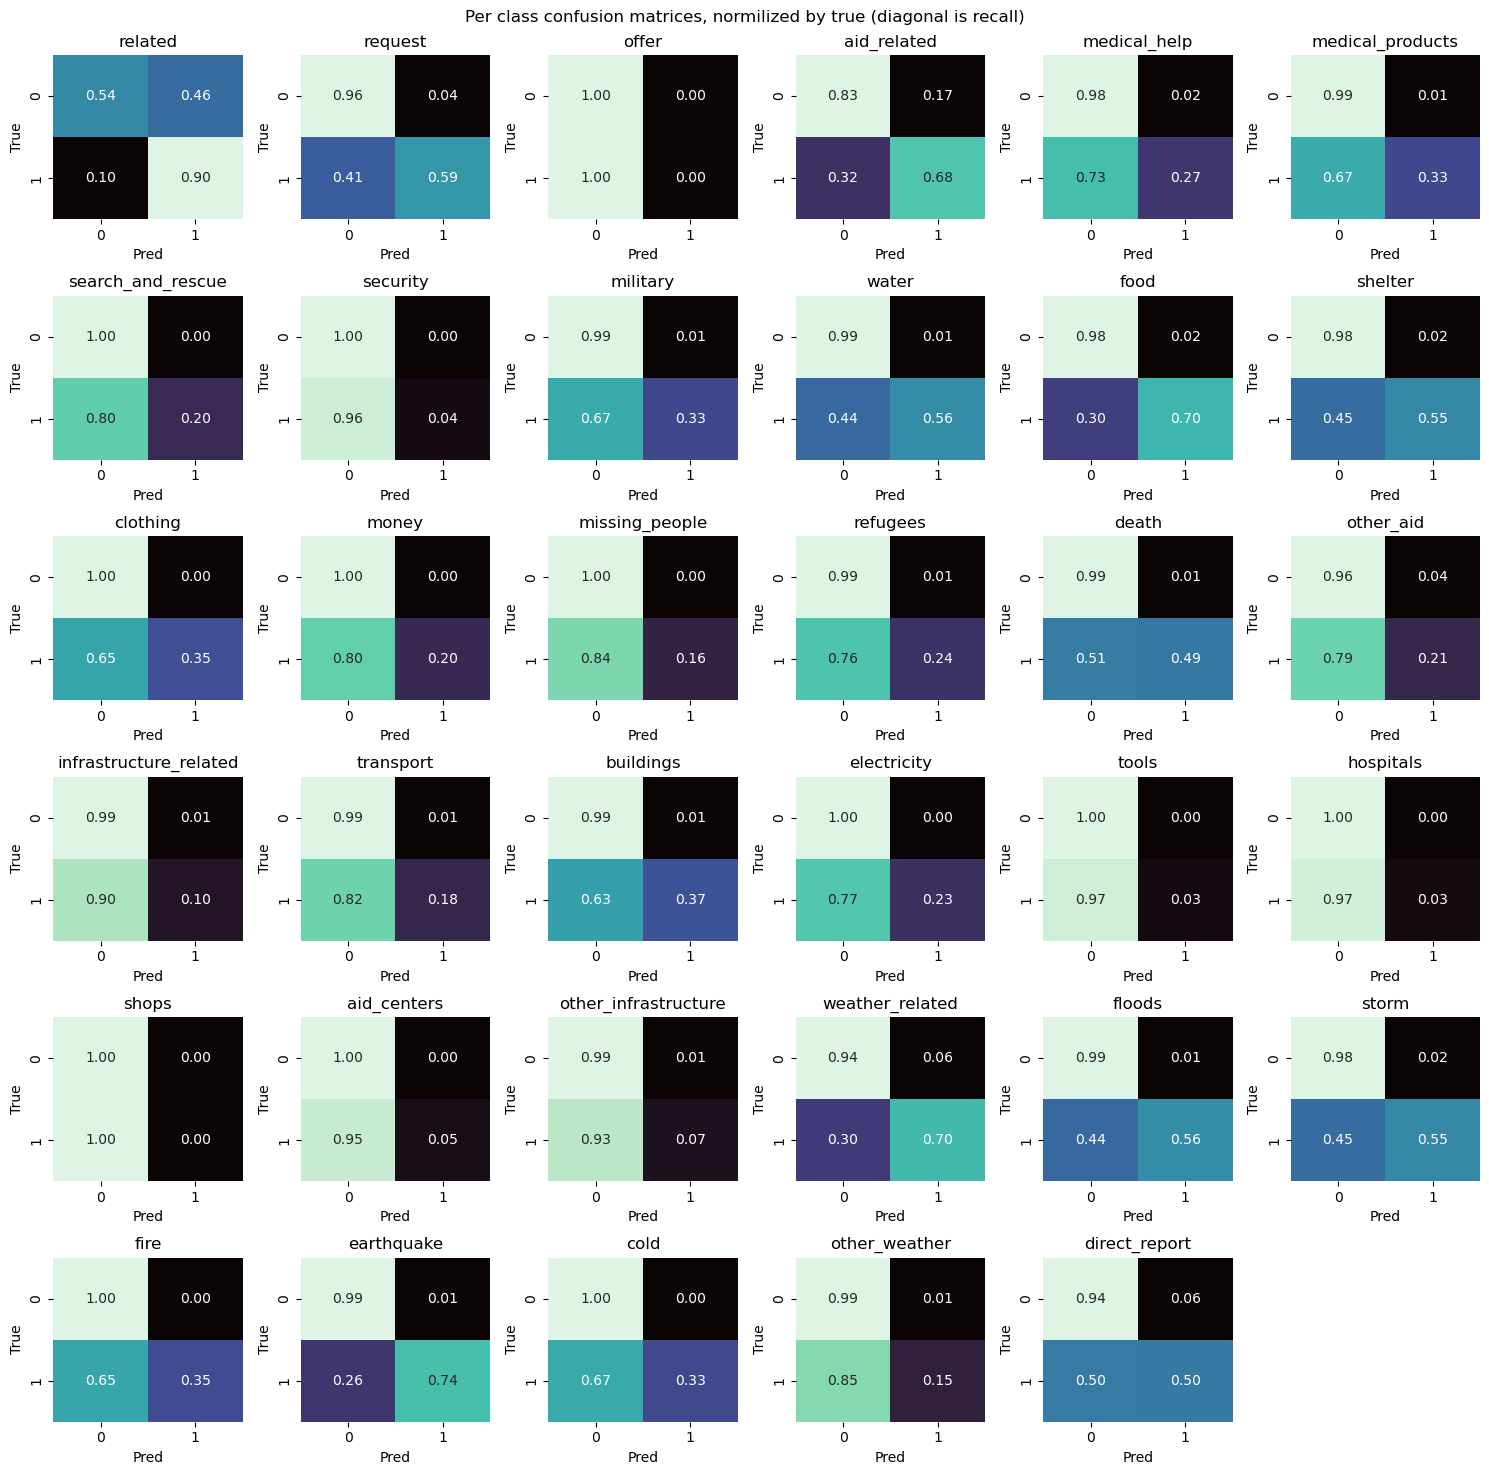

                        precision    recall  f1-score   support

               related       0.87      0.90      0.88      4018
               request       0.76      0.59      0.67       911
                 offer       0.00      0.00      0.00        21
           aid_related       0.75      0.68      0.71      2232
          medical_help       0.58      0.27      0.37       438
      medical_products       0.67      0.33      0.44       265
     search_and_rescue       0.67      0.20      0.31       152
              security       0.43      0.04      0.07        82
              military       0.62      0.33      0.43       166
                 water       0.75      0.56      0.64       345
                  food       0.81      0.70      0.75       607
               shelter       0.75      0.55      0.63       465
              clothing       0.63      0.35      0.45        82
                 money       0.69      0.20      0.31       120
        missing_people       0.56      

In [10]:
clf.fit(tfidf_full, y_full)
print(clf.best_params_)
mutli_svm_tfidf = mutli_svm.set_params(**clf.best_params_)
mutli_svm_tfidf.fit(tfidf_train, y_train)
preds = mutli_svm.predict(tfidf_test)
results(y_test, preds, label_names)

## Sense vectors

Fitting 1 folds for each of 3 candidates, totalling 3 fits
[CV 1/1] END estimator__C=0.1, estimator__penalty=l2;, score=0.178 total time=   7.9s
[CV 1/1] END estimator__C=1, estimator__penalty=l2;, score=0.203 total time=  13.9s
[CV 1/1] END estimator__C=10, estimator__penalty=l2;, score=0.220 total time=  26.5s
{'estimator__C': 10, 'estimator__penalty': 'l2'}


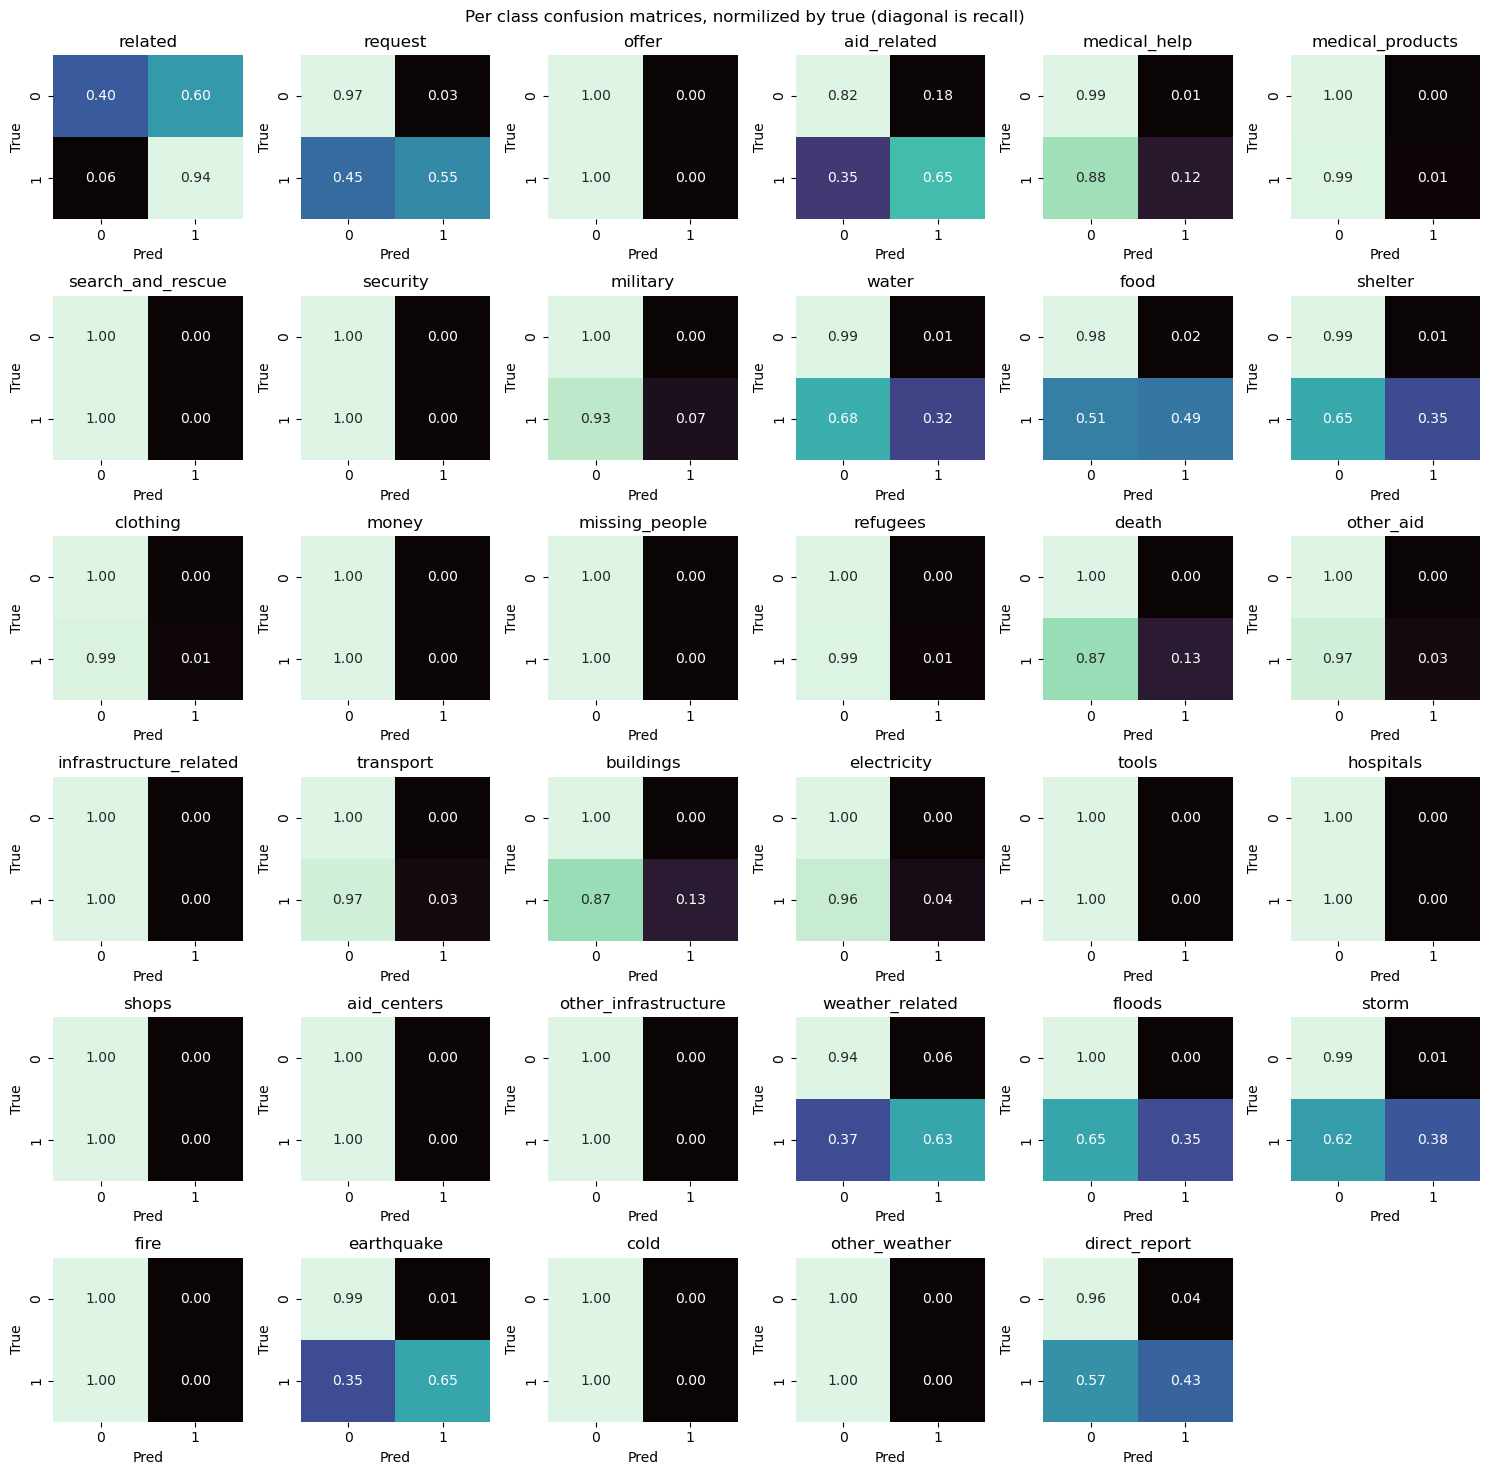

                        precision    recall  f1-score   support

               related       0.84      0.94      0.89      4018
               request       0.77      0.55      0.64       911
                 offer       0.00      0.00      0.00        21
           aid_related       0.73      0.65      0.69      2232
          medical_help       0.55      0.12      0.20       438
      medical_products       0.50      0.01      0.01       265
     search_and_rescue       0.00      0.00      0.00       152
              security       0.00      0.00      0.00        82
              military       0.69      0.07      0.12       166
                 water       0.65      0.32      0.43       345
                  food       0.78      0.49      0.60       607
               shelter       0.78      0.35      0.48       465
              clothing       0.20      0.01      0.02        82
                 money       0.00      0.00      0.00       120
        missing_people       0.00      

In [11]:
clf.fit(sense_full, y_full)
print(clf.best_params_)
mutli_svm_tfidf = mutli_svm.set_params(**clf.best_params_)
mutli_svm_tfidf.fit(sense_train, y_train)
preds = mutli_svm.predict(sense_test)
results(y_test, preds, label_names)

## Logistic Regression

### BOW

Fitting 1 folds for each of 4 candidates, totalling 4 fits
[CV 1/1] END estimator__C=0.01, estimator__penalty=l2, estimator__solver=lbfgs;, score=0.195 total time=   0.8s
[CV 1/1] END estimator__C=0.1, estimator__penalty=l2, estimator__solver=lbfgs;, score=0.337 total time=   0.8s
[CV 1/1] END estimator__C=1, estimator__penalty=l2, estimator__solver=lbfgs;, score=0.414 total time=   1.4s
[CV 1/1] END estimator__C=10, estimator__penalty=l2, estimator__solver=lbfgs;, score=0.414 total time=   2.0s
{'estimator__C': 10, 'estimator__penalty': 'l2', 'estimator__solver': 'lbfgs'}


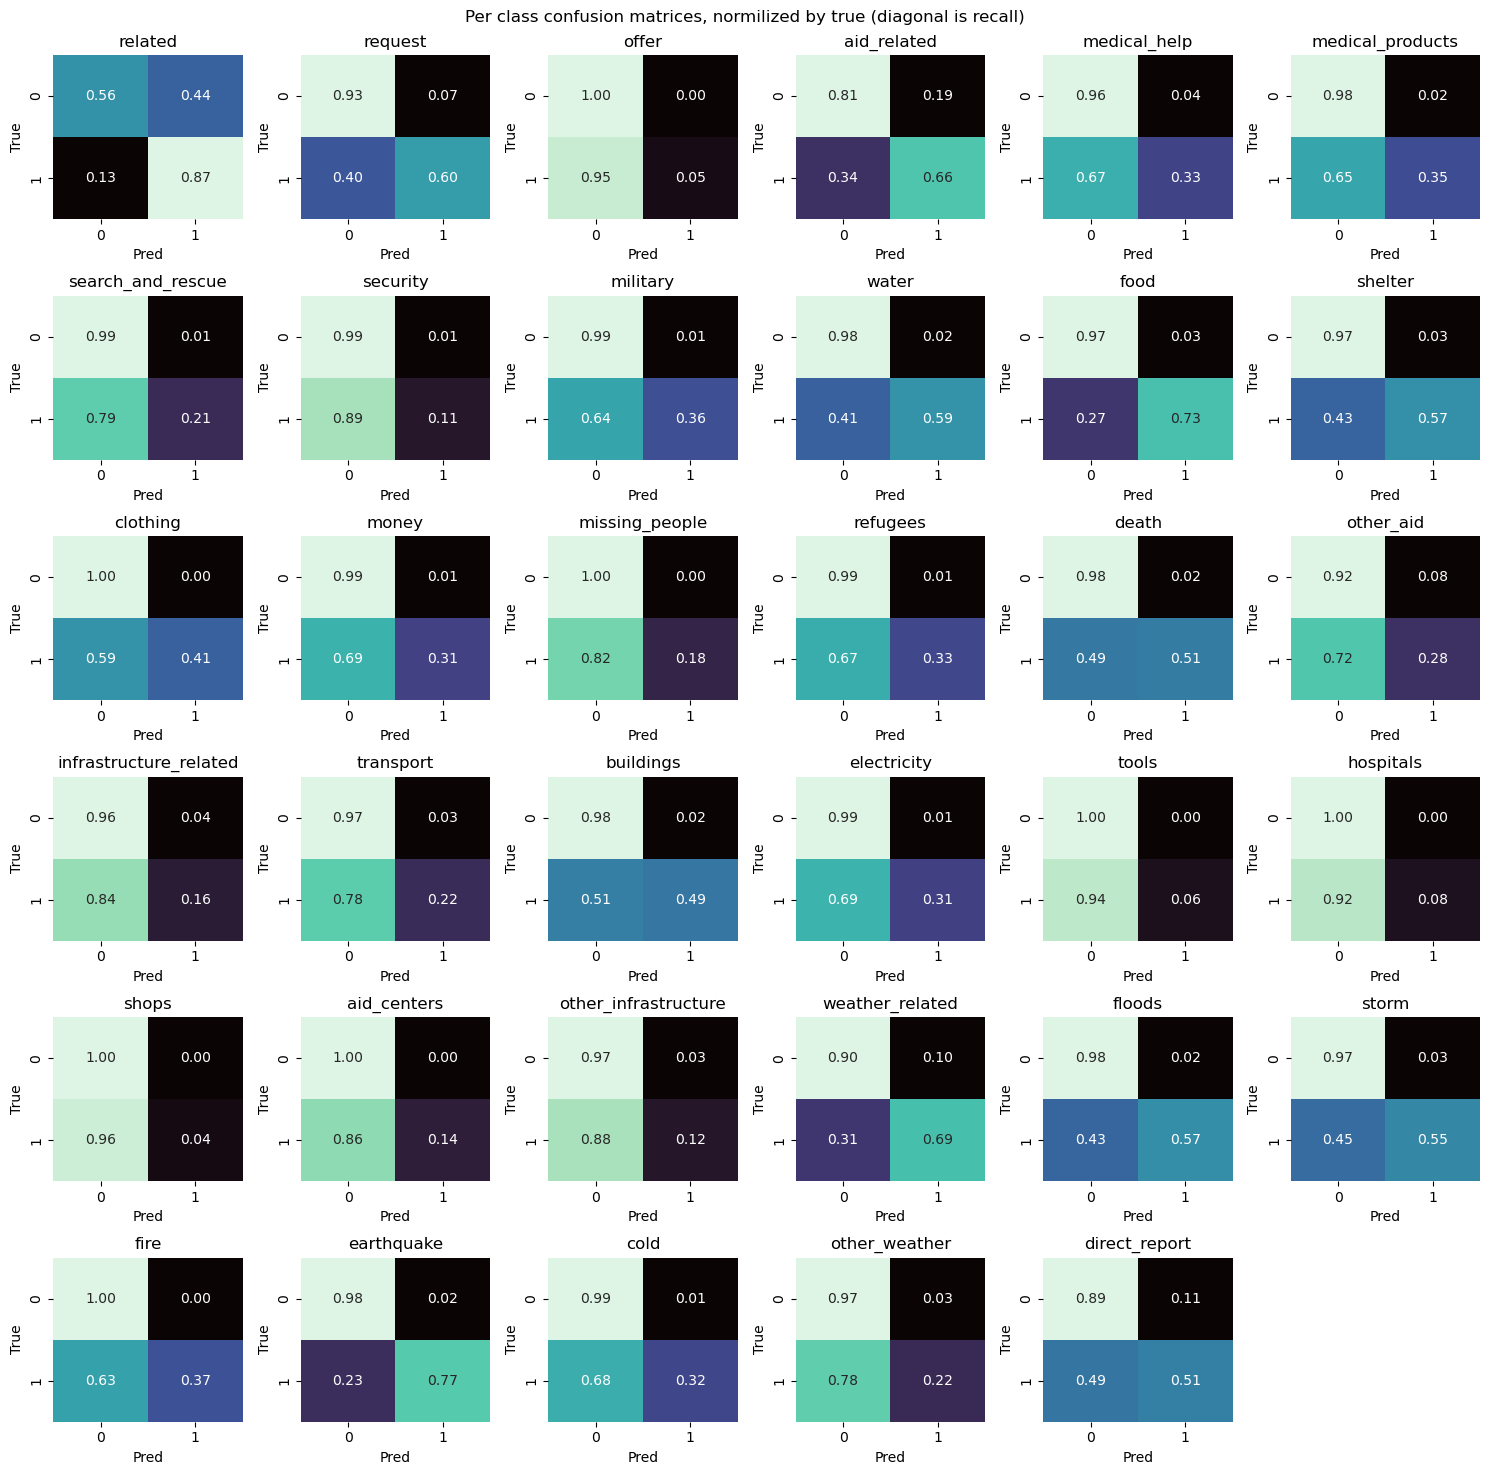

                        precision    recall  f1-score   support

               related       0.87      0.87      0.87      4018
               request       0.64      0.60      0.62       911
                 offer       0.12      0.05      0.07        21
           aid_related       0.72      0.66      0.69      2232
          medical_help       0.41      0.33      0.36       438
      medical_products       0.45      0.35      0.40       265
     search_and_rescue       0.34      0.21      0.26       152
              security       0.22      0.11      0.15        82
              military       0.52      0.36      0.42       166
                 water       0.69      0.59      0.63       345
                  food       0.73      0.73      0.73       607
               shelter       0.64      0.57      0.61       465
              clothing       0.62      0.41      0.50        82
                 money       0.50      0.31      0.38       120
        missing_people       0.42      

In [12]:
from sklearn.linear_model import LogisticRegression
param_grid = {
    'estimator__C': [0.01, 0.1, 1, 10],
    'estimator__penalty': ['l2'],
    'estimator__solver': ['lbfgs'], #lbfgs handles multiclass and is fast
}
mutli_logistic = MultiOutputClassifier(LogisticRegression(), n_jobs=-1)
clf = GridSearchCV(mutli_logistic, param_grid=param_grid, scoring="f1_macro", cv = split, verbose=4, refit=False)
clf.fit(bow_full, y_full)
print(clf.best_params_)
mutli_logistic_bow = mutli_logistic.set_params(**clf.best_params_)
mutli_logistic_bow.fit(bow_train, y_train)
preds = mutli_logistic_bow.predict(bow_test)
results(y_test, preds, label_names)

## TF-IDF

Fitting 1 folds for each of 4 candidates, totalling 4 fits
[CV 1/1] END estimator__C=0.01, estimator__penalty=l2, estimator__solver=lbfgs;, score=0.033 total time=   1.5s
[CV 1/1] END estimator__C=0.1, estimator__penalty=l2, estimator__solver=lbfgs;, score=0.132 total time=   1.6s
[CV 1/1] END estimator__C=1, estimator__penalty=l2, estimator__solver=lbfgs;, score=0.304 total time=   1.9s
[CV 1/1] END estimator__C=10, estimator__penalty=l2, estimator__solver=lbfgs;, score=0.403 total time=   2.2s
{'estimator__C': 10, 'estimator__penalty': 'l2', 'estimator__solver': 'lbfgs'}


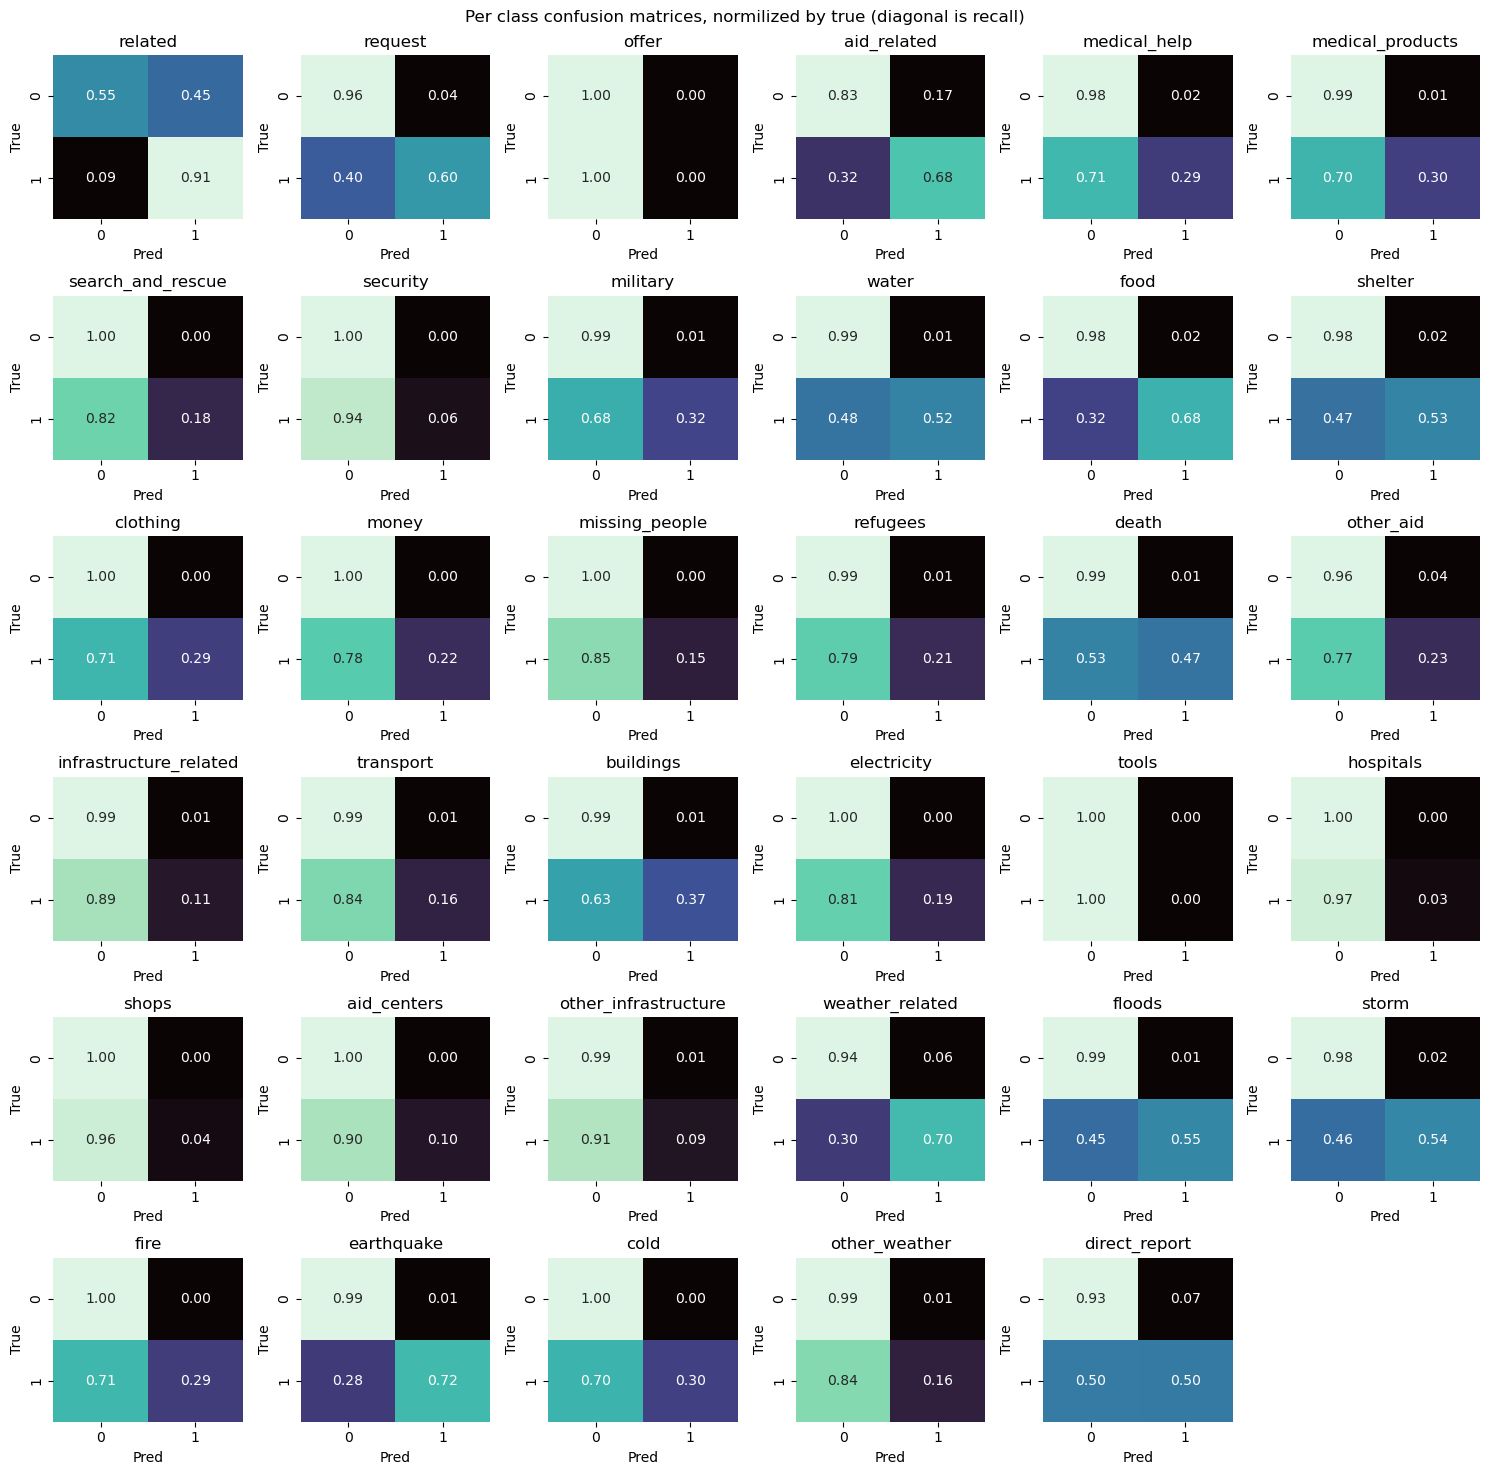

                        precision    recall  f1-score   support

               related       0.87      0.91      0.89      4018
               request       0.77      0.60      0.67       911
                 offer       0.00      0.00      0.00        21
           aid_related       0.75      0.68      0.71      2232
          medical_help       0.59      0.29      0.39       438
      medical_products       0.63      0.30      0.41       265
     search_and_rescue       0.61      0.18      0.28       152
              security       0.45      0.06      0.11        82
              military       0.65      0.32      0.43       166
                 water       0.74      0.52      0.61       345
                  food       0.82      0.68      0.75       607
               shelter       0.74      0.53      0.62       465
              clothing       0.57      0.29      0.39        82
                 money       0.74      0.22      0.34       120
        missing_people       0.56      

In [13]:
clf.fit(tfidf_full, y_full)
print(clf.best_params_)
mutli_logistic_tfidf = mutli_logistic.set_params(**clf.best_params_)
mutli_logistic_tfidf.fit(tfidf_train, y_train)
preds = mutli_logistic_tfidf.predict(tfidf_test)
results(y_test, preds, label_names)

## Sense vectors

Fitting 1 folds for each of 4 candidates, totalling 4 fits
[CV 1/1] END estimator__C=0.01, estimator__penalty=l2, estimator__solver=lbfgs;, score=0.080 total time=   1.8s
[CV 1/1] END estimator__C=0.1, estimator__penalty=l2, estimator__solver=lbfgs;, score=0.155 total time=   2.0s
[CV 1/1] END estimator__C=1, estimator__penalty=l2, estimator__solver=lbfgs;, score=0.211 total time=   2.5s
[CV 1/1] END estimator__C=10, estimator__penalty=l2, estimator__solver=lbfgs;, score=0.246 total time=   3.0s
{'estimator__C': 10, 'estimator__penalty': 'l2', 'estimator__solver': 'lbfgs'}


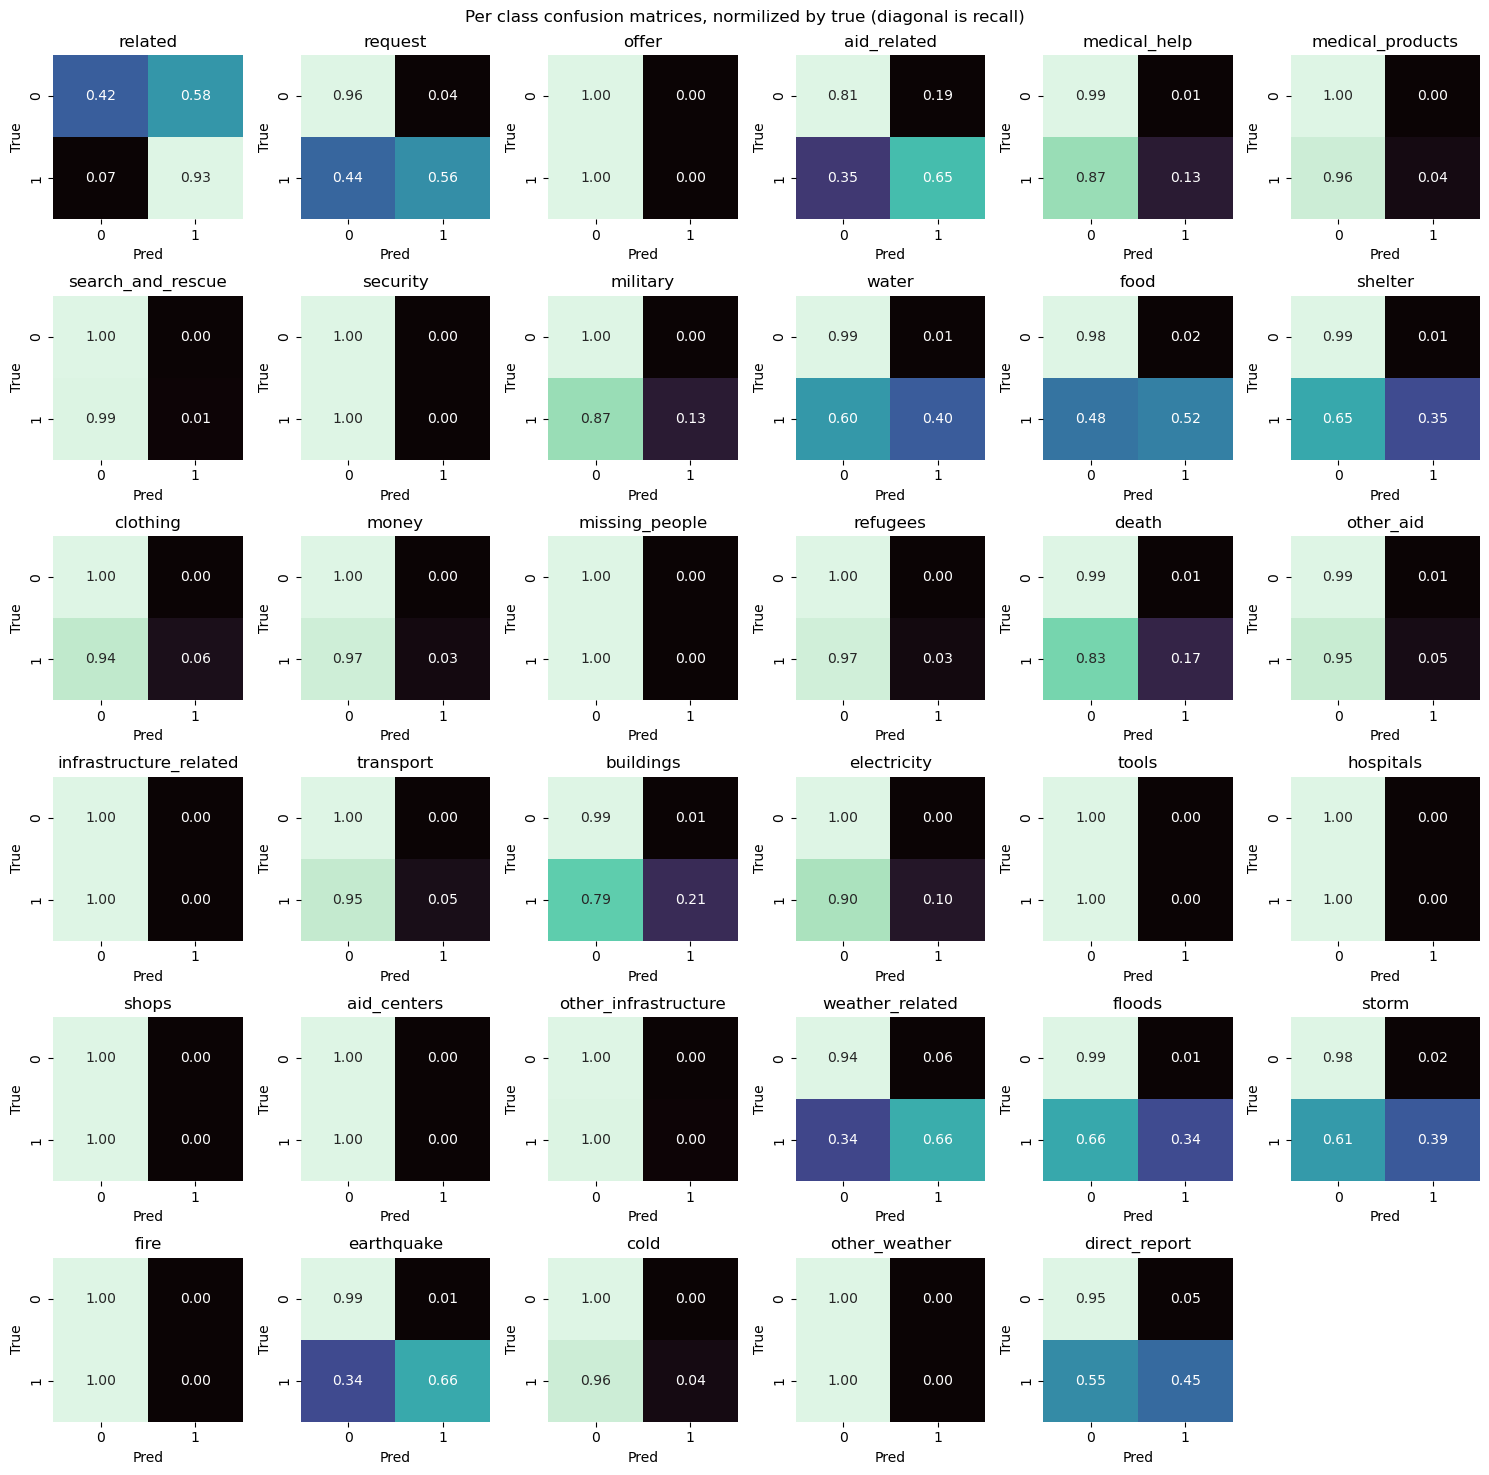

                        precision    recall  f1-score   support

               related       0.84      0.93      0.88      4018
               request       0.77      0.56      0.65       911
                 offer       0.00      0.00      0.00        21
           aid_related       0.72      0.65      0.68      2232
          medical_help       0.53      0.13      0.21       438
      medical_products       0.62      0.04      0.07       265
     search_and_rescue       1.00      0.01      0.01       152
              security       0.00      0.00      0.00        82
              military       0.66      0.13      0.21       166
                 water       0.72      0.40      0.51       345
                  food       0.80      0.52      0.63       607
               shelter       0.73      0.35      0.47       465
              clothing       0.50      0.06      0.11        82
                 money       0.67      0.03      0.06       120
        missing_people       0.00      

In [14]:
clf.fit(sense_full, y_full)
print(clf.best_params_)
mutli_logistic_sense = mutli_logistic.set_params(**clf.best_params_)
mutli_logistic_sense.fit(sense_train, y_train)
preds = mutli_logistic_sense.predict(sense_test)
results(y_test, preds, label_names)

## Random Forest

### BOW

Fitting 1 folds for each of 12 candidates, totalling 12 fits
[CV 1/1] END class_weight=balanced, criterion=gini, min_samples_leaf=2, min_samples_split=2, n_estimators=200;, score=0.251 total time=  18.0s
[CV 1/1] END class_weight=balanced, criterion=gini, min_samples_leaf=2, min_samples_split=2, n_estimators=300;, score=0.258 total time=  26.6s
[CV 1/1] END class_weight=balanced, criterion=gini, min_samples_leaf=2, min_samples_split=5, n_estimators=200;, score=0.249 total time=  17.3s
[CV 1/1] END class_weight=balanced, criterion=gini, min_samples_leaf=2, min_samples_split=5, n_estimators=300;, score=0.255 total time=  25.5s
[CV 1/1] END class_weight=balanced, criterion=gini, min_samples_leaf=2, min_samples_split=10, n_estimators=200;, score=0.254 total time=  16.7s
[CV 1/1] END class_weight=balanced, criterion=gini, min_samples_leaf=2, min_samples_split=10, n_estimators=300;, score=0.254 total time=  24.4s
[CV 1/1] END class_weight=balanced, criterion=gini, min_samples_leaf=5, min_sam

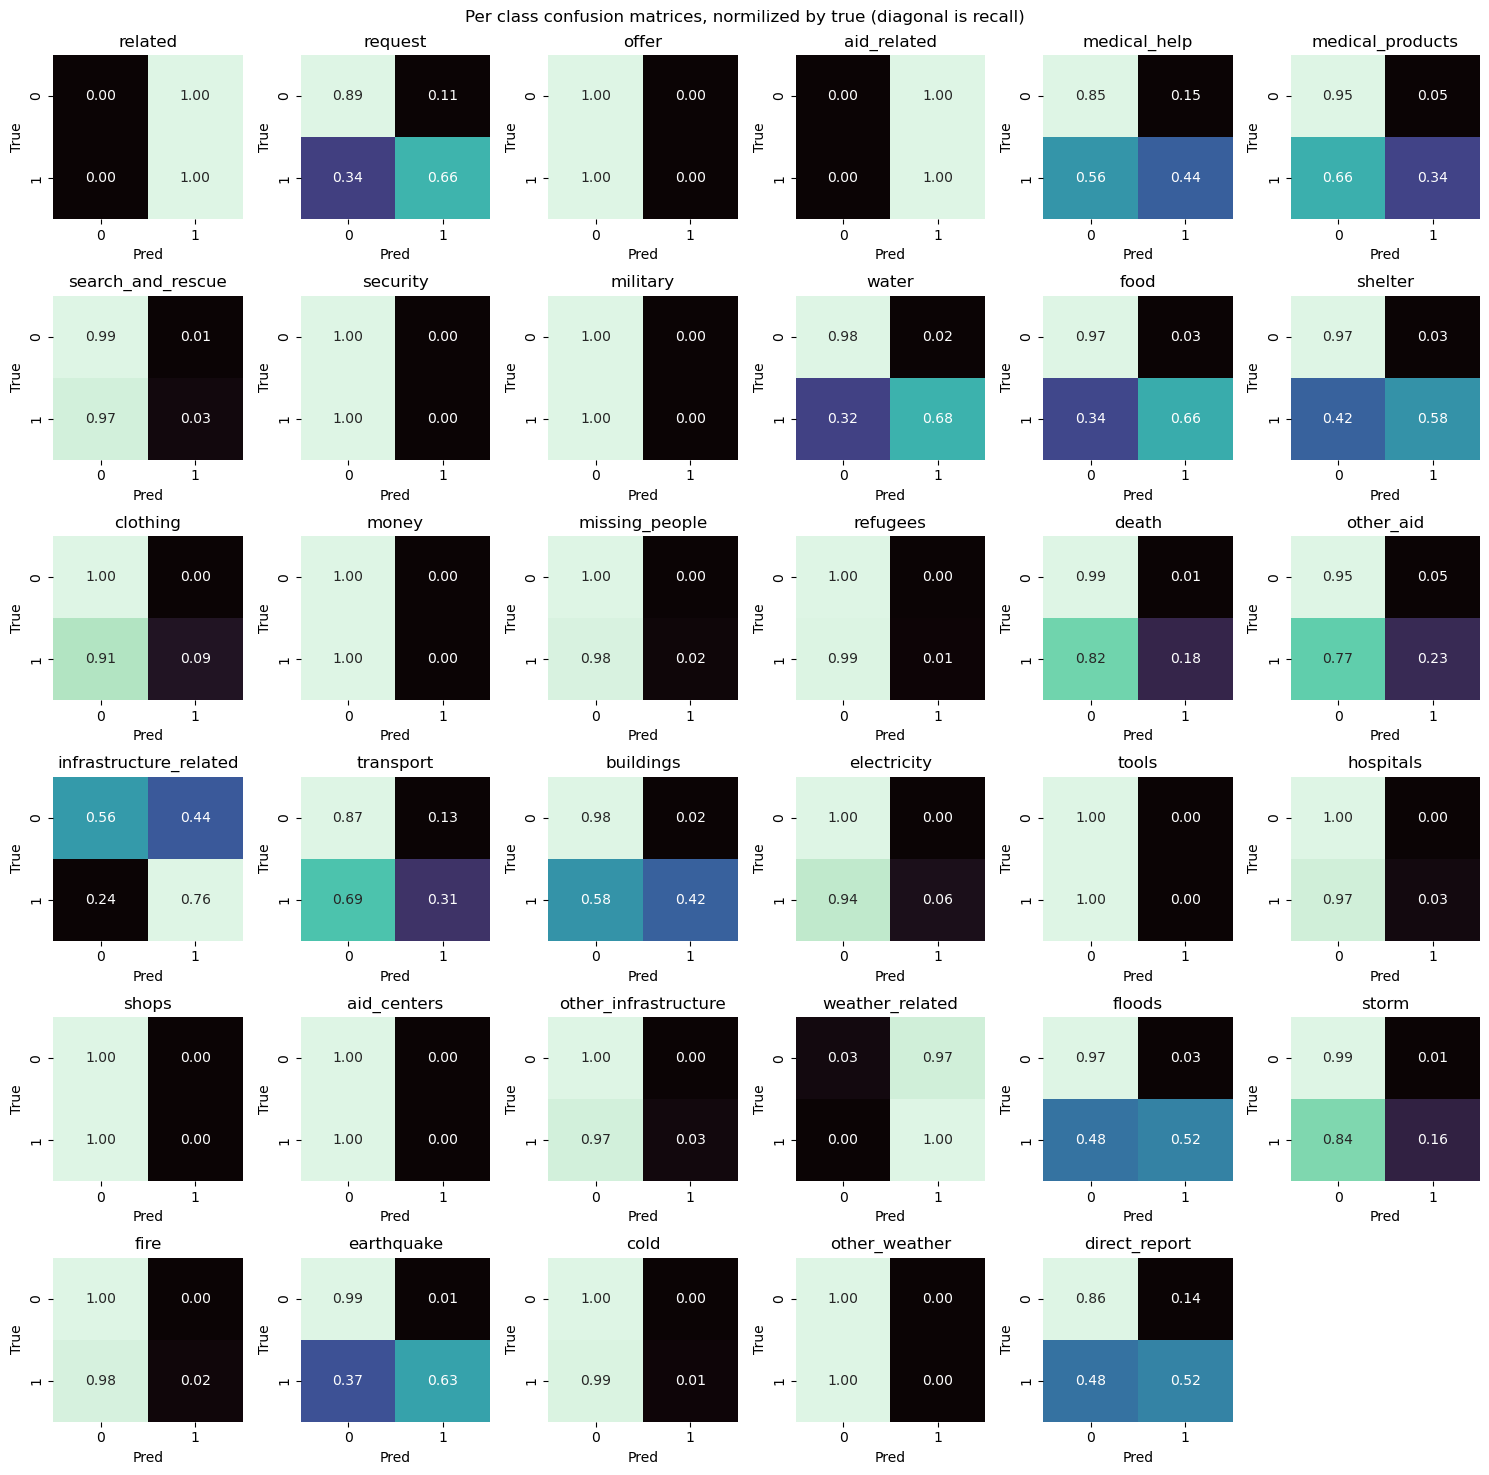

                        precision    recall  f1-score   support

               related       0.77      1.00      0.87      4018
               request       0.56      0.66      0.60       911
                 offer       0.00      0.00      0.00        21
           aid_related       0.43      1.00      0.60      2232
          medical_help       0.20      0.44      0.28       438
      medical_products       0.25      0.34      0.29       265
     search_and_rescue       0.11      0.03      0.05       152
              security       0.00      0.00      0.00        82
              military       0.00      0.00      0.00       166
                 water       0.67      0.68      0.68       345
                  food       0.77      0.66      0.71       607
               shelter       0.63      0.58      0.60       465
              clothing       0.70      0.09      0.15        82
                 money       0.00      0.00      0.00       120
        missing_people       0.10      

In [ ]:
from sklearn.ensemble import RandomForestClassifier
param_grid = {
    "n_estimators": [200, 300], #500
    "criterion": ["gini"],
  #  "max_depth": [None, 50],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [2, 5],
    "class_weight": ["balanced"]
}
rf = RandomForestClassifier(n_jobs=-1,)
clf = GridSearchCV(rf, param_grid=param_grid, scoring="f1_macro", cv = split, verbose=4, refit=False)
clf.fit(bow_full, y_full)
print(clf.best_params_)
rf_bow = rf.set_params(**clf.best_params_)
rf_bow.fit(bow_train, y_train)
preds = rf_bow.predict(bow_test)
results(y_test, preds, label_names)

### TF-IDF

Fitting 1 folds for each of 12 candidates, totalling 12 fits
[CV 1/1] END class_weight=balanced, criterion=gini, min_samples_leaf=2, min_samples_split=2, n_estimators=200;, score=0.254 total time=  23.0s
[CV 1/1] END class_weight=balanced, criterion=gini, min_samples_leaf=2, min_samples_split=2, n_estimators=300;, score=0.254 total time=  35.0s
[CV 1/1] END class_weight=balanced, criterion=gini, min_samples_leaf=2, min_samples_split=5, n_estimators=200;, score=0.251 total time=  22.4s
[CV 1/1] END class_weight=balanced, criterion=gini, min_samples_leaf=2, min_samples_split=5, n_estimators=300;, score=0.252 total time=  35.8s
[CV 1/1] END class_weight=balanced, criterion=gini, min_samples_leaf=2, min_samples_split=10, n_estimators=200;, score=0.251 total time=  22.8s
[CV 1/1] END class_weight=balanced, criterion=gini, min_samples_leaf=2, min_samples_split=10, n_estimators=300;, score=0.252 total time=  33.4s
[CV 1/1] END class_weight=balanced, criterion=gini, min_samples_leaf=5, min_sam

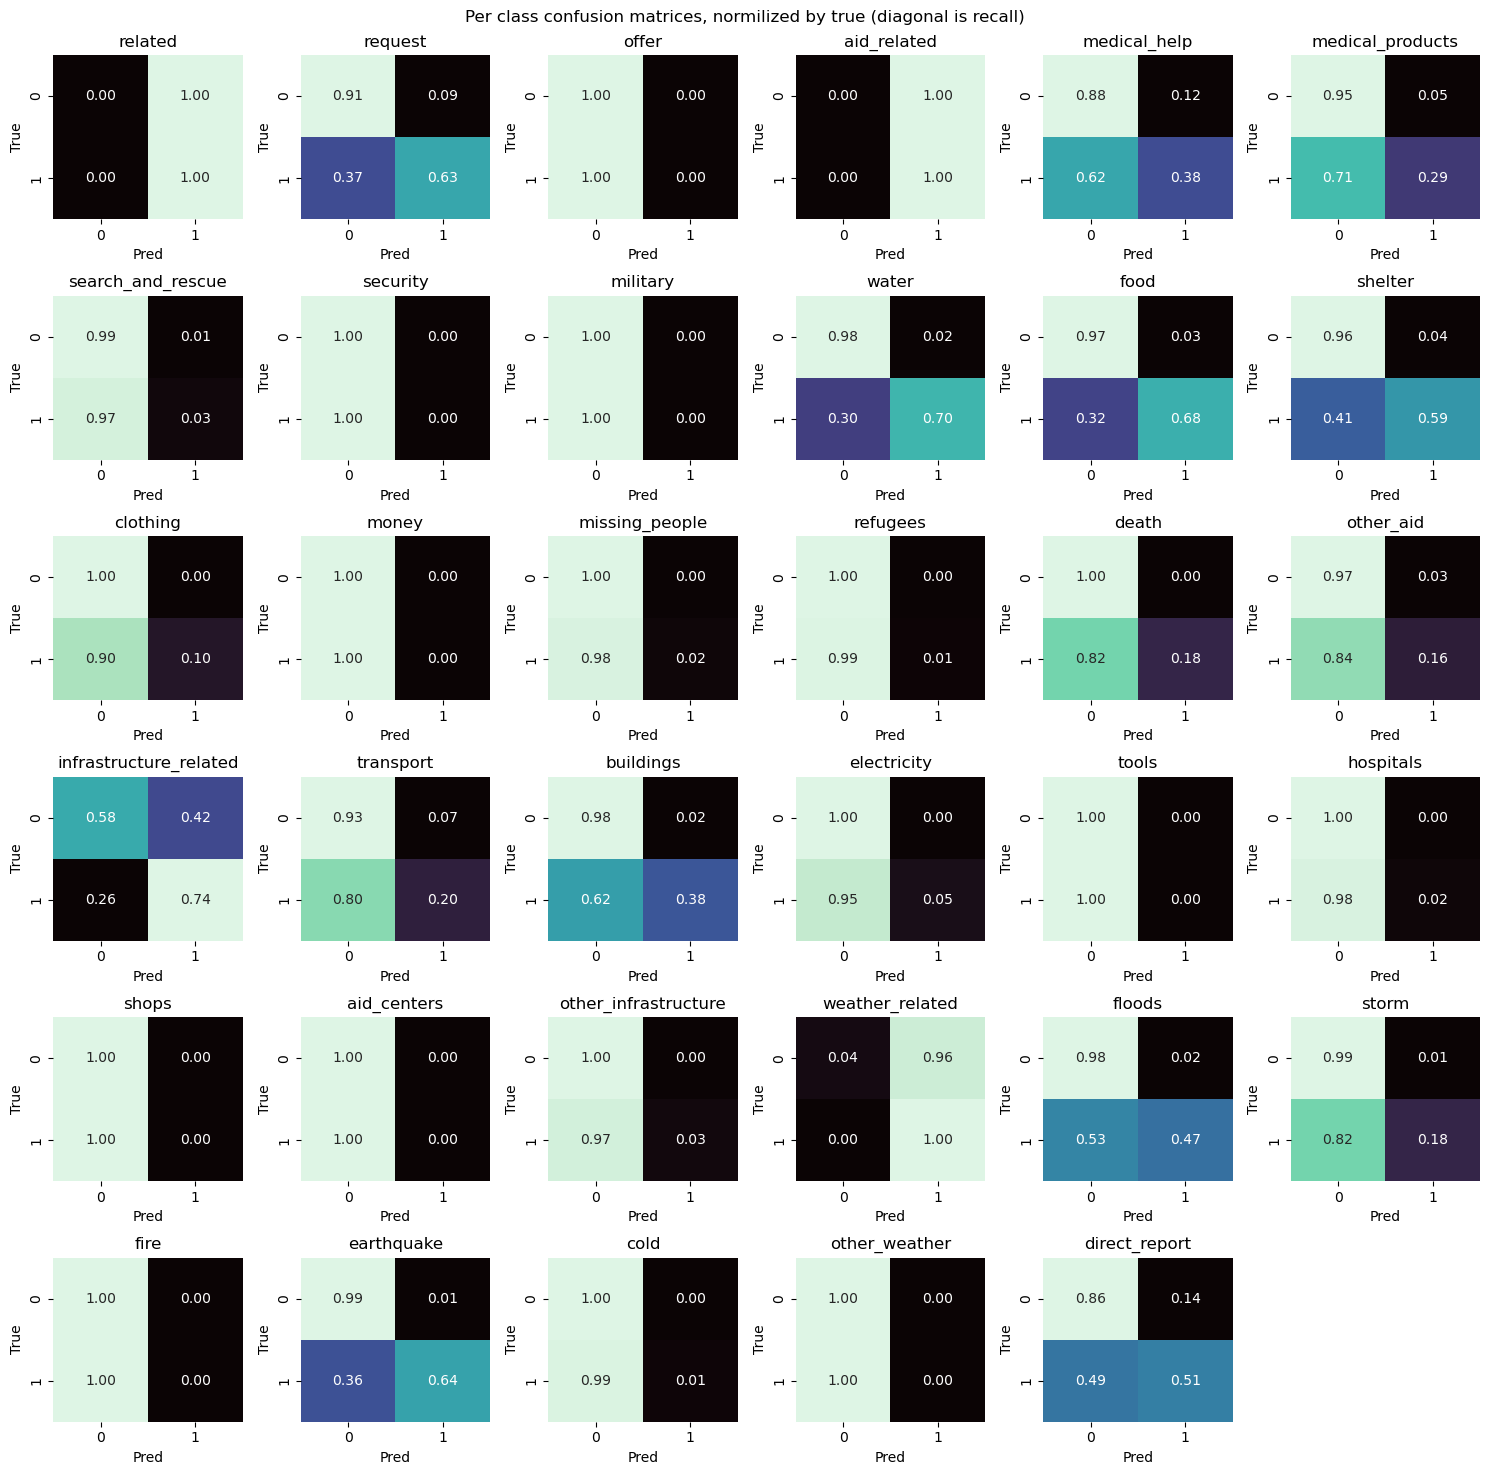

                        precision    recall  f1-score   support

               related       0.77      1.00      0.87      4018
               request       0.60      0.63      0.61       911
                 offer       0.00      0.00      0.00        21
           aid_related       0.43      1.00      0.60      2232
          medical_help       0.23      0.38      0.28       438
      medical_products       0.25      0.29      0.27       265
     search_and_rescue       0.08      0.03      0.05       152
              security       0.00      0.00      0.00        82
              military       0.00      0.00      0.00       166
                 water       0.66      0.70      0.68       345
                  food       0.77      0.68      0.72       607
               shelter       0.56      0.59      0.57       465
              clothing       0.57      0.10      0.17        82
                 money       0.00      0.00      0.00       120
        missing_people       0.25      

In [18]:
clf.fit(tfidf_full, y_full)
print(clf.best_params_)
rf_tfidf = rf.set_params(**clf.best_params_)
rf_tfidf.fit(tfidf_train, y_train)
preds = rf_tfidf.predict(tfidf_test)
results(y_test, preds, label_names)

### Sense vectors

Fitting 1 folds for each of 12 candidates, totalling 12 fits
[CV 1/1] END class_weight=balanced, criterion=gini, min_samples_leaf=2, min_samples_split=2, n_estimators=200;, score=0.255 total time= 1.1min
[CV 1/1] END class_weight=balanced, criterion=gini, min_samples_leaf=2, min_samples_split=2, n_estimators=300;, score=0.255 total time= 1.7min
[CV 1/1] END class_weight=balanced, criterion=gini, min_samples_leaf=2, min_samples_split=5, n_estimators=200;, score=0.261 total time= 1.1min
[CV 1/1] END class_weight=balanced, criterion=gini, min_samples_leaf=2, min_samples_split=5, n_estimators=300;, score=0.260 total time= 1.6min
[CV 1/1] END class_weight=balanced, criterion=gini, min_samples_leaf=2, min_samples_split=10, n_estimators=200;, score=0.275 total time= 1.0min
[CV 1/1] END class_weight=balanced, criterion=gini, min_samples_leaf=2, min_samples_split=10, n_estimators=300;, score=0.274 total time= 1.5min
[CV 1/1] END class_weight=balanced, criterion=gini, min_samples_leaf=5, min_sam

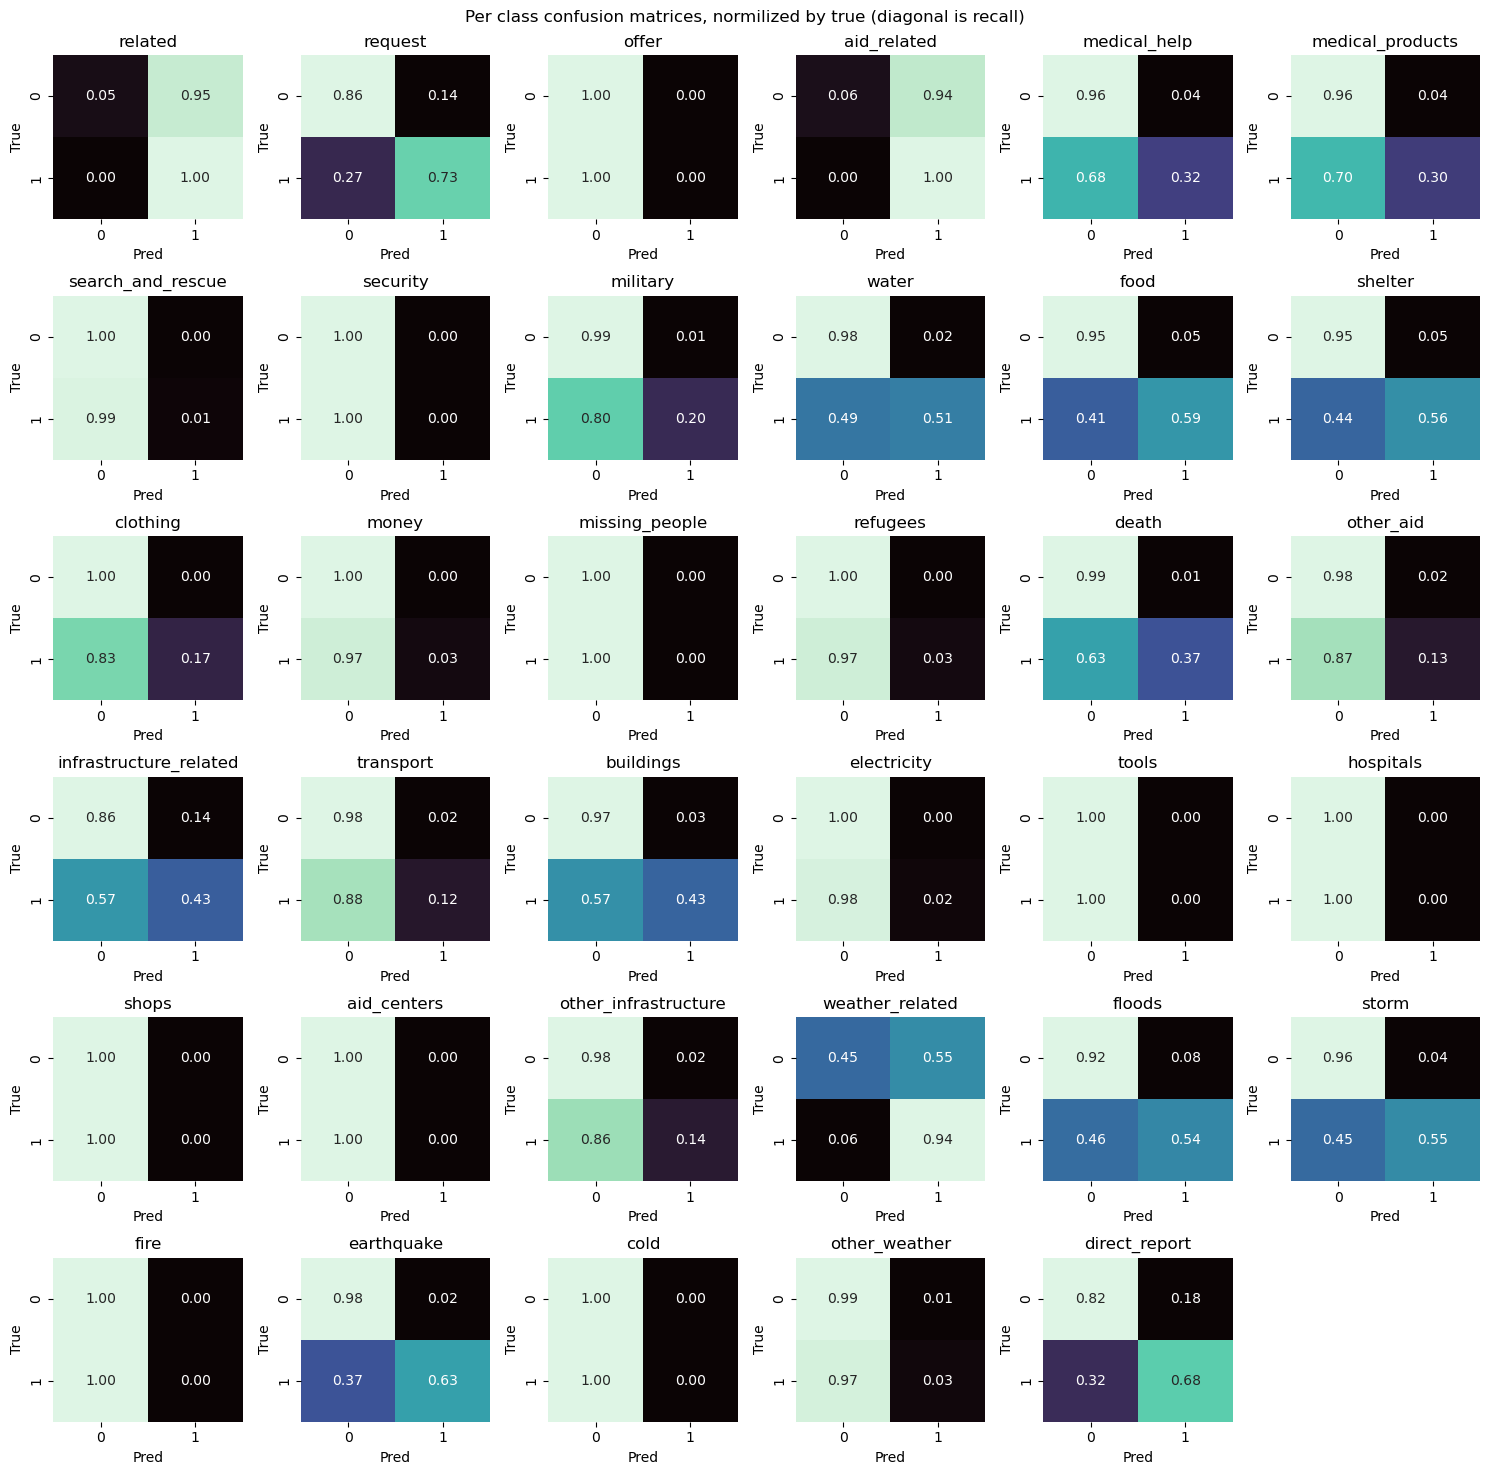

                        precision    recall  f1-score   support

               related       0.78      1.00      0.87      4018
               request       0.53      0.73      0.61       911
                 offer       0.00      0.00      0.00        21
           aid_related       0.44      1.00      0.61      2232
          medical_help       0.41      0.32      0.36       438
      medical_products       0.30      0.30      0.30       265
     search_and_rescue       0.15      0.01      0.02       152
              security       0.00      0.00      0.00        82
              military       0.56      0.20      0.30       166
                 water       0.59      0.51      0.55       345
                  food       0.60      0.59      0.59       607
               shelter       0.51      0.56      0.53       465
              clothing       0.36      0.17      0.23        82
                 money       0.80      0.03      0.06       120
        missing_people       0.00      

In [19]:
clf.fit(sense_full, y_full)
print(clf.best_params_)
rf_sense = rf.set_params(**clf.best_params_)
rf_sense.fit(sense_train, y_train)
preds = rf_sense.predict(sense_test)
results(y_test, preds, label_names)